# EMAT30008 Scientific Computing

Michael Johnson - fr19042@bristol.ac.uk - 1962648

## Introduction

In this report, we will be show casing the capabilities of code written for this unit to solve ODEs, PDEs and performing numerical continuation, As well as this we'll be discussing the design choices and learning process that went along with this project.

## Summary of Software

The software consists of four modules: 
1) integrate: contains solve_to function for integrating ODEs
2) BVP: contains shooting and solve_BVP
3) continuation: contains continuation for solving ODE equilibria/period orbits for varying parameters.
4) PDEs : Contains diffusion_solver for solving the diffusion-reaction equation.

Let's start by importing the libraries to plot results.

In [1]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root
%matplotlib inline

#### ODE integration methods

The module integrate.py consists of three functions, euler_step, RK4_step and solve_to. euler_step and RK4_step both increment a solution by a single time step according to the forward euler and fourth order runge-kutta methods respectively. The core function is solve_to which calls either euler_step or RK4_step depending on user input to integrate an ODE over some time span. The user can choose a start and end time, the time-stepping method used and the size of time-step for integrating the chosen ODE with initial condition x0.

We can perform a simple demonstration for two ODEs as outlined in the table below. The code is shown handling different solution dimensions, time spans and parameters alongside the analytical solution.

<style>
table {
  border-collapse: collapse;
  width: 100%;
}
th, td {
  border: 1px solid black;
  padding: 8px;
  text-align: left;
  vertical-align: top;
}
th {
  background-color: #f2f2f2;
}
.math {
  display: block;
  text-align: left;
  margin-bottom: 1em;
}
</style>

<table>
    <tr>
        <th style="width: 15%;"> </th>
        <th style="width: 45%;">ODE Equation</th>
        <th style="width: 40%;">True Solution</th>
    </tr>
    <tr>
        <td></td>
        <td><div class="math">$\dot{x}(t) = x(t)$</div></td>
        <td><div class="math">$ x(t) = x_{0}e^{t} $</div></td>
    </tr>
    <tr>
        <td>Hopf Normal Form:</td>
        <td>
            <div class="math">$\dot{u_1} = \beta u_1 - u_2 + \sigma u_1(u_1^2 + u_2^2)$</div>
            <div class="math">$\dot{u_2} = u_1 + \beta u_2 + \sigma u_2(u_1^2 + u_2^2)$</div>
        </td>
        <td>
            <div class="math">$u_1(t) = \sqrt{\beta} \cos(t+\theta)$</div>
            <div class="math">$u_2(t) = \sqrt{\beta} \sin(t+\theta)$</div>
        </td>
    </tr>
</table>



In [ ]:
from integrate import solve_to
from functions import f, hopf_normal_form,hopf_normal_form_sol

result = solve_to(func=f, x0=[1], t=[0, 1], parameters=None, deltat_max=0.05, method='RK4')
x = result.x[0]
t = result.t_space

plt.style.use('seaborn-v0_8-dark')
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

ax0.plot(t, np.exp(t), linewidth=2, label='Analytical Solution')
ax0.plot(t, x, 'o', markersize=6, label='Numerical Solution')
ax0.set_title("ODE: x' = x", fontsize=16)
ax0.set(xlabel='t', ylabel='x')
ax0.set_xlabel('t', fontsize=14)
ax0.set_ylabel('x', fontsize=14)
ax0.legend(fontsize=12, loc="upper left")
ax0.grid(True)

beta = 10
theta = 0
result = solve_to(func=hopf_normal_form, x0=[5, 1], t=[0, 20], parameters=[beta, -1], deltat_max=0.1, method='RK4')
x = result.x
t = result.t_space

# Analytical solution
x1_analytical = np.sqrt(beta) * np.cos(t+theta)
x2_analytical = np.sqrt(beta) * np.sin(t+theta)

# 3D plot
ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.plot(x1_analytical, x2_analytical, t, color='blue', linewidth=2, label='Analytical Solution')
ax1.scatter(x[0], x[1], t, c='r', marker='o', s=30, label='Numerical Solution')
ax1.set_title("Hopf Normal Form", fontsize=16, pad=30)  # Add pad to adjust title position
ax1.set_xlabel('x1', fontsize=14, labelpad=10)
ax1.set_ylabel('x2', fontsize=14, labelpad=10)
ax1.set_zlabel('t', fontsize=14, labelpad=2)
ax1.legend(fontsize=12)

plt.tight_layout()

#### ODE BVP solvers

The module BVP consists of three functions, lim_cycle_conditions, BVP_solver and shooting with the latter two working to solve boundary value ODE problems. lim_cycle_conditions returns an array containing the difference between the final and initial solution for a given ODE as well as the first derivative of the first component at time t = 0. This function is then called in shooting which uses a numerical solver such as scipy.optimize.root to solve for and return the conditions for a limit cycle of a chosen ODE. The final function BVP solver uses a finite difference analogue to discretize the time invariant diffusion reaction ODE and solve for given boundary conditions, source term and diffusion coefficient.

Time-invariant diffusion-reaction equation: $$0 = D \frac{\partial^2 u}{\partial x^2} + q(x,u)$$

Below we will demonstrate the code isolating a a limit cycle for the hopf normal form ODE and predator prey model as well as solving the time invariant diffusion-reaction equation for a variety of conditions.

| ODE name                                  | Governing equation                                          |
|-------------------------------------------|--------------------------------------------------------------|
| Predator Prey Model                       | $\dot{x} = x(1-x) - \frac{ax}{d+x}y$<br> $\dot{y} = by\left(1-\frac{x}{y}\right)$ |
| Time Invariant Diffusion Reaction Equation| $$\frac{\partial^2u}{\partial x^2} + q(x,u) = 0$$                                    |

Firstly let's 

#### PDE Integration methods

The module PDEs.py consists of several functions that aim to solve a one-dimensional diffusion equation with given boundary and initial conditions as well as a source term. The code allows users to choose from various finite difference methods for solving the problem, such as explicit Euler, implicit Euler, Crank-Nicolson, and IMEX (Implicit-Explicit) methods.

The gen_diag_mat function generates a diagonal matrix of size NxN using the given entries for the diagonal elements. The Grid function creates a grid with specified grid points, grid spacing, and domain limits. The BoundaryCondition function sets up the boundary condition type (Dirichlet, Neumann, or Robin) and the corresponding values for each boundary condition.

The construct_A_and_b function builds the A matrix and b vector, which are used in the finite difference method based on the given boundary conditions and the grid. The du_dt function computes the explicit temporal derivative of u. The main function, diffusion_solver, iterates over a specified time range and uses the chosen finite difference method to solve for the solution u(x,t) of the diffusion equation with given boundary conditions, initial conditions, diffusion coefficient, and source term.

The solution is returned as a class containing the solution array u, the time steps array t, and the grid points array x. The user can also choose between dense and sparse storage for the A matrix.

Below we will demonstrate the code working for a range of boundary and initial value problems as well as linear and non-linear source terms, with a variety of finite difference methods to solve the 1d reaction diffusion equation: $$\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2} + q(x,t,u)$$


<table>
  <tr>
    <th style="width: 5%;">#</th>
    <th style="width: 30%;">Left Boundary Condition</th>
    <th>Right Boundary Condition</th>
    <th>Initial<br>Condition</th>
    <th>Source Term</th>
  </tr>
  <tr>
    <td>1</td>
    <td>$u(0,t) = \sin(t)$</td>
    <td>$\frac{\partial u}{\partial x}(1,t) = 2$</td>
    <td>$u(x,0) =$<br>$\sin(2\pi x)$</td>
    <td>$q(x,t,u) =$<br>$0$</td>
  </tr>
  <tr>
    <td>2</td>
    <td>$u(0,t) = 5$</td>
    <td>$u(10,t) = 10$</td>
    <td>$u(x,0) = 0$</td>
    <td>$q(x,t,u) =$<br>$5x^2 + t - \sin(u)$</td>
  </tr>
  <tr>
    <td>3</td>
    <td>$\frac{\partial u}{\partial x}(0,t) = 5 - 2u(0,t)$</td>
    <td>$\frac{\partial u}{\partial x}(5,t) = e^{-t}$</td>
    <td>$u(x,0) = 5$</td>
    <td>$q(x,t,u) =$<br>$2+ t $</td>
  </tr>
</table>


First let's generate the results:


In [ ]:
from PDEs import Grid, BoundaryCondition, diffusion_solver

t_steps = 1000

# problem 1

grid = Grid(N=10, a=0, b=1)
bc_left = BoundaryCondition('dirichlet', [lambda t: np.sin(t)], grid)
bc_right = BoundaryCondition('neumann', [2], grid)
IC = lambda x: np.sin(2*np.pi*x)

result = diffusion_solver(grid,bc_left,bc_right,IC,D=1,q=0,dt=0.1,t_steps=1000,method='implicit-euler',storage='sparse')

x1 = result.x
u1 = result.u
t_span1 = result.t

# problem 2

grid = Grid(N=10, a=0, b=10)
bc_left = BoundaryCondition('dirichlet', [5], grid)
bc_right = BoundaryCondition('dirichlet', [10], grid)
q2 = lambda x,t,u: 5*x**2 + t - np.sin(u)

result = diffusion_solver(grid,bc_left,bc_right,IC=0,D=1,q=q2,dt=0.1,t_steps=t_steps,method='IMEX',storage='dense')

u2 = result.u
x2 = result.x
t_span2 = result.t

# problem 3

grid = Grid(N=10, a=0, b=5)
bc_left = BoundaryCondition('robin', [5, 2], grid)
bc_right = BoundaryCondition('neumann', [lambda t: np.exp(-t)], grid)
q3 = lambda x,t,u: 2 + 50*t
IC = 5

result = diffusion_solver(grid,bc_left,bc_right,IC=5,D=1,q=q3,dt=0.1,t_steps=t_steps,method='lines',storage='sparse')

u3 = result.u
x3 = result.x
t_span3 = result.t



Now, we will plot the time against domain against solution u using plotly's 3d plotting library:

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a 1x3 subplot layout
fig = make_subplots(rows=1, cols=3, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]], 
                    subplot_titles=('Problem 1', 'Problem 2', 'Problem 3'),
                    horizontal_spacing=0)

# Add the Surface plots to each subplot
fig.add_trace(go.Surface(z=u1, x=t_span1, y=x1), row=1, col=1)
fig.update_traces(showscale=False)
fig.add_trace(go.Surface(z=u2, x=t_span2, y=x2), row=1, col=2)
fig.update_traces(showscale=False)
fig.add_trace(go.Surface(z=u3, x=t_span3, y=x3), row=1, col=3)
fig.update_traces(showscale=False)


# Update the overall layout
fig.update_layout(
    scene=dict(
        xaxis_title='t',
        yaxis_title='x',
        zaxis_title='u',
        xaxis=dict(range=[0, 5])
    ),
    scene2=dict(
        xaxis_title='t',
        yaxis_title='x',
        zaxis_title='u',
        xaxis=dict(range=[0, 5]),
        zaxis=dict(range=[0, 1000])
    ),
    scene3=dict(
        xaxis_title='t',
        yaxis_title='x',
        zaxis_title='u',
        xaxis=dict(range=[0, 5]),
        zaxis=dict(range=[0, 1000])
    ),
    autosize=False,
    width=1500,
    height=500,
    margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()


We can better visualise the time dependant boundary conditions by animating the solution in time for problem 1:

In [ ]:
from matplotlib.animation import FuncAnimation

%matplotlib widget
fig,ax = plt.subplots()

line, = ax.plot(x1,u1[:,0])
ax.set_ylim(-5,5)
ax.set_xlim(0,1)

ax.set_xlabel('x')
ax.set_ylabel('u')
ax.set_title('Problem 1')

def animate(i):
    line.set_data((x1,u1[:,i]))
    return line,

ani = FuncAnimation(fig, animate, frames=t_steps, interval=100, blit=True)

#### Continuation

Function: continuation(myode, x0, par0, vary_par, step_size, max_steps, solve_for, method, solver) performs numerical continuation to solve some function, myode, given a varying parameter.

Allows user to choose a varying parameter based on its index in the parameters argument as part of chosen function = myode(x,t,parameters). User can choose between 'nParam' for natural parameter continuation or 'pArclength' for pseudo-arclength continuation. We will see in an example how natural parameter continuation fails against the analytical solution.

We will now demonstrate continuation used for solving equilibria of a basic ODE as well as isolating limit cycles in the predator prey model and varying mu in the Bratu diffusion reaction equation. When solving for limit cycles, for the relevant plot each point on the surface corresponds to a condition for a limit cycle in the predator prey model.

<style>
table {
  border-collapse: collapse;
  width: 100%;
}
th, td {
  border: 1px solid black;
  padding: 8px;
  text-align: left;
}
th {
  background-color: #f2f2f2;
}
.math {
  display: inline-block;
  text-align: center;
}
</style>

|                     | ODE Equation                                                                                      |
|---------------------|---------------------------------------------------------------------------------------------------|
|                     | <div class="math">${\dot{x}}^3 - x + \alpha = 0$</div>                                             |
| Predator-Prey Model | <div class="math">$\dot{x} = x(1 - x) - \frac{axy}{d + x}$<br/>$\dot{y} = by\left(1 - \frac{x}{y}\right)$</div>|
| Bratu Problem       | <div class="math">$D\frac{d^2u}{dx^2} + e^{\mu u} = 0,\, u(0) = u(1) = 0$</div>                     |



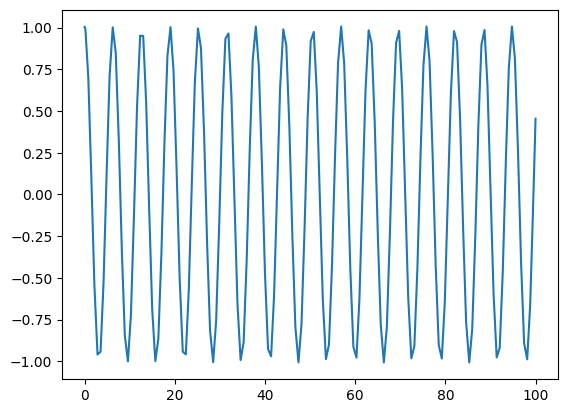

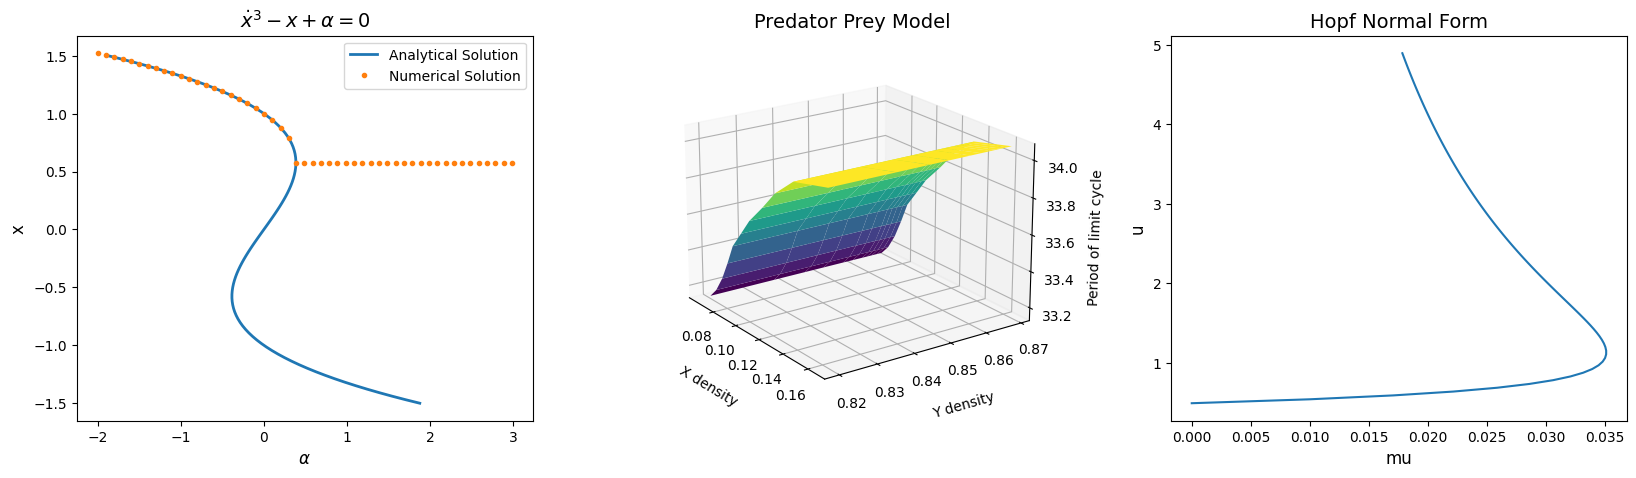

In [2]:
from continuation import continuation
from functions import bratu, h, PPM
from PDEs import Grid, BoundaryCondition, construct_A_and_b

plt.style.use('default')

y = np.linspace(-1.5,1.5,100)

result = continuation(h,x0 = [1],par0 = [-2],
                   vary_par = 0,
                   step_size = 0.1,
                   max_steps = 50,
                   solve_for = 'equilibria',
                   method = 'nParam')

u = result.u
alpha = result.alpha

fig = plt.figure(figsize=(20, 5))

# Create the first plot
ax0 = fig.add_subplot(1, 3, 1)
ax0.plot(y - y**3, y, label='Analytical Solution', linewidth=2)
ax0.plot(alpha, u[0], 'o', markersize=3, label='Numerical Solution')
ax0.set_title(r"$\dot{x}^3 - x + \alpha = 0$", fontsize=14)
ax0.set(xlabel=r'$\alpha$', ylabel='x')
ax0.xaxis.label.set_size(12)
ax0.yaxis.label.set_size(12)
ax0.legend(loc="best")

# Numerical continuation on the PPM problem for limit cycles

result = continuation(PPM,x0 = [0.5,0.5,20],par0 = [1,0.1,0.1],
                   vary_par = 0,
                   step_size = 0.1,
                   max_steps = 10,
                   solve_for = 'limit_cycle',
                   method = 'pArclength')

u = result.u
alpha = result.alpha

# Create the 3D axis for the middle plot
ax1 = fig.add_subplot(1, 3, 2, projection='3d')


# Create a 3D surface plot of u[0] against u[1] against u[2]
X, Y = np.meshgrid(u[1], u[0])
Z = np.array([u[2] for _ in range(len(u[0]))])

ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_title("Predator Prey Model", fontsize=14)
ax1.set_xlabel('X density', labelpad=10)  # Add padding to the axis label
ax1.set_ylabel('Y density', labelpad=10)  # Add padding to the axis label
ax1.set_zlabel('Period of limit cycle', labelpad=5)  # Add padding to the axis label
ax1.view_init(elev=20, azim=-35)  # Adjust the viewing angle

grid = Grid(N=100, a=0, b=10)
bc_left = BoundaryCondition('dirichlet', [lambda t: 5],grid);bc_right = BoundaryCondition('dirichlet',[lambda t: 10],grid)
A,b = construct_A_and_b(grid,bc_left,bc_right)
dx = grid.dx
u0 = np.zeros(len(grid.x[1:-1]))

# Numerical continuation on Bratu problem

result = continuation(bratu,  # the ODE to use
    x0 = u0,  # the initial state
    par0=[0,1,dx,A],  # the initial parameters
    vary_par=0,  # the index of the parameter to vary
    step_size=0.01,  # the size of the steps to take
    max_steps=100,  # the number of steps to take
    solve_for = 'equilibria', # 'equilibria' or 'limit cycle'
    method = 'pArclength',
    solver=root)

u=result.u
alpha = result.alpha

# Create the last plot
ax2 = fig.add_subplot(1, 3, 3)
ax2.plot(alpha, u[0])
ax2.set_title("Hopf Normal Form", fontsize=14)
ax2.set(xlabel='mu', ylabel='u')
ax2.xaxis.label.set_size(12)
ax2.yaxis.label.set_size(12)

## Key Software Decisions (40% of report mark)

The key design decisions should be described; explain your thinking behind the overall structure and interfaces of your code. 
If your code structure is intricate, a block diagram might be appropriate. 
Why were the solvers implemented as they are? 
What alternative designs might have been appropriate and why were they not pursued?

things to talk about:

why did i make the output a class in solve_to function?

why all results are from t=0

why combine ODEs into a single py file?

first two arguments of ODEs to solve must be x,t even when autonomous

way of setting up PDE solver means user needs to use BoundaryCondition, Grid functions

choose from RK4 and euler using string (user can't choose their own stepping function)



## Reflective learning log (30% of report mark)

What did I learn about the mathematical algorithms? I.e., solving boundary value problems, numerical ill-conditioning, etc.

What did I learn about software engineering? How have I progressed in my abilities?

What are the short-term implications of what I've learnt? (When will it be useful?)

What are the long-term implications of what I've learnt? (When will it be useful?)

What would I have done differently if I started the unit over again?

What will I do differently in the future?